In [132]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
import seaborn as sns

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import pickle
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [109]:
SAVEE = "./surrey-audiovisual-expressed-emotion-savee/ALL/"

dir_list = os.listdir(SAVEE)
dir_list[0:5]

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_surprise     60
male_angry        60
male_disgust      60
male_happy        60
male_fear         60
male_sad          60
Name: labels, dtype: int64

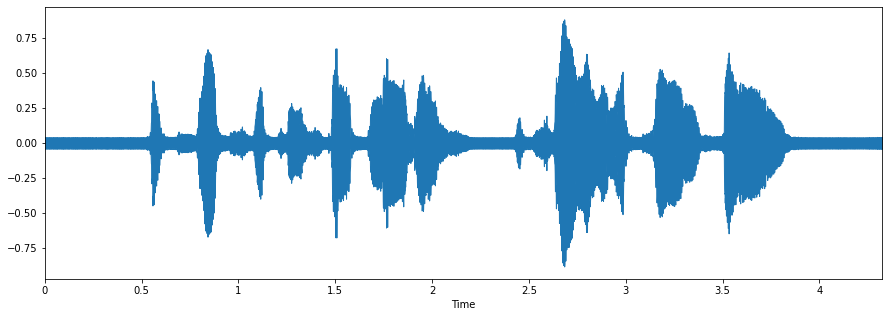

In [110]:
# use the well known Librosa library for this task 
fname = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

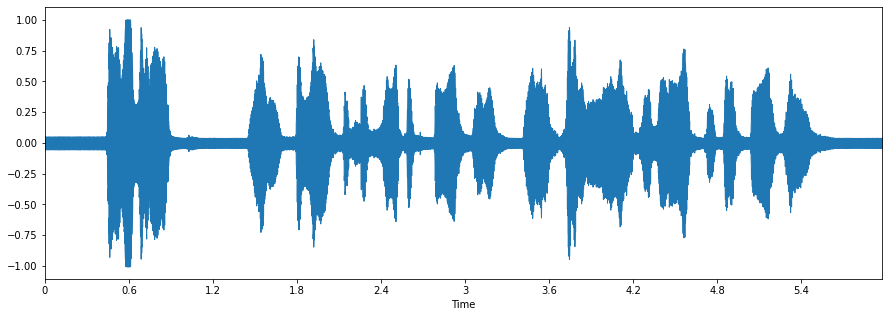

In [111]:
# Lets play a happy track
fname = SAVEE + 'DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [112]:
df = pd.concat([SAVEE_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

male_neutral     120
male_surprise     60
male_angry        60
male_disgust      60
male_happy        60
male_fear         60
male_sad          60
Name: labels, dtype: int64


In [113]:
ref = pd.read_csv("./Data_path.csv")
ref.head()

,labels,source,path
0,male_surprise,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...
1,male_disgust,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...
2,male_sad,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...
3,male_neutral,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...
4,male_fear,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...


In [114]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

480


,feature
0,"[-12.981858, -8.290446, -9.102726, -10.725917,..."
1,"[-21.808826, -20.760191, -20.099804, -19.57644..."
2,"[-23.083853, -24.508183, -25.800497, -25.81244..."
3,"[-21.946795, -24.404602, -28.342669, -28.69042..."
4,"[-18.48146, -17.797667, -17.086615, -17.084848..."


In [115]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-12.981858,-8.290446,-9.102726,-10.725917,-10.041570,-13.318968,-15.079294,...,-25.084116,-26.953909,-28.918745,-28.394785,-26.758858,-27.620451,-27.888903,-28.871305,-27.902433,-28.278313
1,male_disgust,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-21.808826,-20.760191,-20.099804,-19.576448,-21.374199,-20.974916,-14.662622,...,-12.326412,-12.382397,-10.909575,-14.025702,-14.896978,-16.858629,-16.690781,-18.804874,-19.592939,-19.472935
2,male_sad,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-23.083853,-24.508183,-25.800497,-25.812447,-25.330353,-25.587337,-24.315901,...,-21.284842,-24.307209,-25.792307,-24.032122,-22.448215,-23.190315,-25.918852,-26.512857,-25.227467,-26.435982
3,male_neutral,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-21.946795,-24.404602,-28.342669,-28.690428,-29.809692,-29.449776,-27.577909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_fear,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-18.481461,-17.797667,-17.086615,-17.084848,-11.211791,-8.667980,-9.105359,...,-21.702221,-23.318228,-24.405172,-22.551899,-23.627489,-24.426266,-22.887173,-22.679098,-24.837475,-26.007231


In [116]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(480, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-12.981858,-8.290446,-9.102726,-10.725917,-10.041570,-13.318968,-15.079294,...,-25.084116,-26.953909,-28.918745,-28.394785,-26.758858,-27.620451,-27.888903,-28.871305,-27.902433,-28.278313
1,male_disgust,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-21.808826,-20.760191,-20.099804,-19.576448,-21.374199,-20.974916,-14.662622,...,-12.326412,-12.382397,-10.909575,-14.025702,-14.896978,-16.858629,-16.690781,-18.804874,-19.592939,-19.472935
2,male_sad,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-23.083853,-24.508183,-25.800497,-25.812447,-25.330353,-25.587337,-24.315901,...,-21.284842,-24.307209,-25.792307,-24.032122,-22.448215,-23.190315,-25.918852,-26.512857,-25.227467,-26.435982
3,male_neutral,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-21.946795,-24.404602,-28.342669,-28.690428,-29.809692,-29.449776,-27.577909,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_fear,SAVEE,./surrey-audiovisual-expressed-emotion-savee/A...,-18.481461,-17.797667,-17.086615,-17.084848,-11.211791,-8.667980,-9.105359,...,-21.702221,-23.318228,-24.405172,-22.551899,-23.627489,-24.426266,-22.887173,-22.679098,-24.837475,-26.007231


In [117]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
223,-31.584694,-29.984287,-29.250206,-29.803484,-30.581224,-28.661186,-28.160933,-27.006512,-26.204756,-25.817556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
403,3.529948,3.393501,1.581123,0.117456,-2.944853,-3.056373,-1.175402,-2.136642,-4.292752,-5.937325,...,-7.376307,-7.628754,-6.795521,-6.259952,-5.866019,-5.707147,-5.065528,-4.295854,2.169407,7.545354
219,-25.166016,-25.300224,-13.570848,-8.007904,-5.615486,0.178876,1.945374,-1.766074,-5.953430,-7.960311,...,-14.349864,-15.182061,-16.296860,-14.974913,-12.968953,-14.336393,-13.519533,-12.155203,-4.496453,1.279285
129,4.857963,2.180288,-2.770249,-1.995827,-0.780680,-0.125299,-0.136834,-2.471160,-7.706021,-13.459490,...,-27.778399,-27.038452,-26.411522,-25.299252,-25.261127,-24.063915,-24.168633,-23.207539,-23.683941,-23.100679
405,-28.023487,-27.012541,-24.843077,-26.073839,-26.605957,-25.415707,-26.137461,-25.882572,-26.144011,-25.485994,...,-9.703569,-9.060267,-10.795532,-11.224798,-10.564188,-10.653914,-10.423874,-10.612707,-9.730200,-6.192753
278,-16.607304,-20.362644,-28.685890,-28.028978,-30.085140,-31.538404,-30.330540,-32.387249,-31.970198,-30.251207,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
317,-17.551937,-19.298704,-23.825205,-24.564623,-25.068417,-24.967304,-24.442879,-23.588316,-23.557972,-23.233547,...,-40.988518,-42.109932,-41.116493,-39.522259,-40.195652,-39.787422,-39.560284,-40.109909,-41.402920,-43.502476
478,-16.661367,-18.899099,-24.841061,-25.966814,-26.068300,-25.504353,-25.606323,-24.935524,-24.932604,-26.173288,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
280,-21.316029,-21.405161,-23.427490,-22.760799,-23.077984,-22.940372,-22.521370,-22.318233,-23.623758,-22.484484,...,-40.074905,-30.090427,-25.397209,-24.566366,-25.313780,-27.188734,-27.189812,-26.741161,-24.144053,-21.752968
342,-26.271126,-26.805941,-26.244438,-22.448414,-15.879806,-10.738601,-9.642438,-10.089642,-10.519408,-12.317103,...,-18.128660,-22.005880,-23.998308,-18.744484,-13.680187,-13.157104,-11.318650,-10.470745,-8.521368,-5.005698


In [118]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
223,-1.055188,-0.980237,-0.889510,-0.977996,-1.097168,-0.922879,-0.902170,-0.805883,-0.725292,-0.689155,...,1.231312,1.246593,1.261870,1.276021,1.272908,1.265978,1.247717,1.238785,1.119428,0.982256
403,2.436807,2.566163,2.669756,2.374979,1.910007,1.806728,1.929372,1.774567,1.548754,1.363778,...,0.629849,0.614815,0.689651,0.741445,0.771529,0.778020,0.817436,0.877600,1.296375,1.562979
219,-0.416879,-0.482554,0.920565,1.464442,1.619409,2.151623,2.256829,1.813016,1.376407,1.154874,...,0.061225,-0.010716,-0.110411,-0.002779,0.164427,0.040224,0.099329,0.216805,0.752676,1.080715
129,2.568873,2.437259,2.167420,2.138162,2.145495,2.119196,2.038347,1.739858,1.194522,0.587001,...,-1.033737,-0.992608,-0.962118,-0.884438,-0.886208,-0.791474,-0.805237,-0.712449,-0.812348,-0.795674
405,-0.701042,-0.664488,-0.380737,-0.560048,-0.664611,-0.576894,-0.689851,-0.689265,-0.718988,-0.654917,...,0.440084,0.496263,0.352830,0.317466,0.369967,0.355074,0.362283,0.346494,0.325786,0.505634
278,0.434247,0.042066,-0.824363,-0.779143,-1.043188,-1.229605,-1.129822,-1.364178,-1.323635,-1.146996,...,1.231312,1.246593,1.261870,1.276021,1.272908,1.265978,1.247717,1.238785,1.119428,0.982256
317,0.340307,0.155110,-0.263230,-0.390923,-0.497307,-0.529092,-0.512041,-0.451217,-0.450607,-0.422317,...,-2.110889,-2.240760,-2.200353,-2.099029,-2.162690,-2.135825,-2.112648,-2.133559,-2.257592,-2.365886
478,0.428870,0.197568,-0.380504,-0.548054,-0.606107,-0.586344,-0.634119,-0.591001,-0.593267,-0.725890,...,1.231312,1.246593,1.261870,1.276021,1.272908,1.265978,1.247717,1.238785,1.119428,0.982256
280,-0.034015,-0.068702,-0.217317,-0.188785,-0.280724,-0.313010,-0.310421,-0.319436,-0.457434,-0.344965,...,-2.036393,-1.245359,-0.876708,-0.821853,-0.890708,-1.058644,-1.061864,-1.009547,-0.849877,-0.691948
342,-0.526777,-0.642536,-0.542514,-0.153778,0.502526,0.987763,1.040942,0.949379,0.902546,0.704970,...,-0.246898,-0.575834,-0.758913,-0.324686,0.103637,0.141052,0.286278,0.358430,0.424384,0.596995


In [119]:
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
223,-0.273451,-0.230877,-0.189076,-0.185812,-0.243706,-0.186036,-0.169756,-0.147706,-0.137293,-0.095439,...,0.487702,0.496502,0.500000,0.487629,0.485814,0.499204,0.500000,0.500000,0.451971,0.348008
403,0.361759,0.440612,0.500000,0.478190,0.362847,0.378750,0.423038,0.393051,0.348178,0.346558,...,0.329692,0.328951,0.350051,0.348625,0.354457,0.367821,0.385706,0.401856,0.500000,0.491578
219,-0.157340,-0.136644,0.161355,0.297873,0.304233,0.450112,0.491593,0.401109,0.311384,0.301581,...,0.180309,0.163056,0.140395,0.155107,0.195402,0.169170,0.194958,0.222300,0.352425,0.372350
129,0.385782,0.416205,0.402747,0.431293,0.410346,0.443403,0.445852,0.385778,0.272555,0.179317,...,-0.107349,-0.097349,-0.082793,-0.074148,-0.079854,-0.054764,-0.045318,-0.030204,-0.072365,-0.091542
405,-0.209031,-0.171092,-0.090577,-0.103044,-0.156458,-0.114448,-0.125306,-0.123268,-0.135947,-0.088068,...,0.279839,0.297510,0.261787,0.238379,0.249252,0.253943,0.264806,0.257540,0.236556,0.230175
278,-0.002516,-0.037311,-0.176464,-0.146432,-0.232818,-0.249501,-0.217416,-0.264702,-0.265029,-0.194013,...,0.487702,0.496502,0.500000,0.487629,0.485814,0.499204,0.500000,0.500000,0.451971,0.348008
317,-0.019604,-0.015906,-0.067828,-0.069552,-0.122713,-0.104557,-0.088081,-0.073383,-0.078652,-0.037989,...,-0.390328,-0.428367,-0.407271,-0.389974,-0.414280,-0.416730,-0.392600,-0.416359,-0.464643,-0.479739
478,-0.003494,-0.007867,-0.090532,-0.100669,-0.144658,-0.116403,-0.113639,-0.102676,-0.109108,-0.103348,...,0.487702,0.496502,0.500000,0.487629,0.485814,0.499204,0.500000,0.500000,0.451971,0.348008
280,-0.087695,-0.058284,-0.058939,-0.029521,-0.079027,-0.059848,-0.045871,-0.045767,-0.080110,-0.021335,...,-0.370757,-0.164380,-0.060412,-0.057874,-0.081033,-0.126700,-0.113485,-0.110934,-0.082551,-0.065899
342,-0.177331,-0.166936,-0.121898,-0.022589,0.078956,0.209297,0.237042,0.220125,0.210223,0.204716,...,0.099362,0.013183,-0.029544,0.071402,0.179476,0.196318,0.244617,0.260783,0.263318,0.252762


In [120]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(360, 216)
['male_angry' 'male_disgust' 'male_fear' 'male_happy' 'male_neutral'
 'male_sad' 'male_surprise']


In [121]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(360, 216, 1)

In [122]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
#model.add(Dense(14)) # Target class number
model.add(Dense(7)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
activation_37 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_9 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_38 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 27, 256)          

In [123]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

Train on 360 samples, validate on 120 samples
Epoch 1/10
360/360 [==============================] - 10s 27ms/step - loss: 1.9050 - accuracy: 0.2306 - val_loss: 1.9459 - val_accuracy: 0.1167
Epoch 2/10
360/360 [==============================] - 9s 24ms/step - loss: 1.8387 - accuracy: 0.3000 - val_loss: 1.9460 - val_accuracy: 0.1250
Epoch 3/10
360/360 [==============================] - 9s 24ms/step - loss: 1.8120 - accuracy: 0.3222 - val_loss: 1.9464 - val_accuracy: 0.1250
Epoch 4/10
360/360 [==============================] - 9s 24ms/step - loss: 1.7772 - accuracy: 0.3250 - val_loss: 1.9468 - val_accuracy: 0.1250
Epoch 5/10
360/360 [==============================] - 9s 24ms/step - loss: 1.7546 - accuracy: 0.3222 - val_loss: 1.9473 - val_accuracy: 0.1250
Epoch 6/10
360/360 [==============================] - 9s 24ms/step - loss: 1.7207 - accuracy: 0.3194 - val_loss: 1.9478 - val_accuracy: 0.1250
Epoch 7/10
360/360 [==============================] - 9s 24ms/step - loss: 1.6985 - accuracy: 0

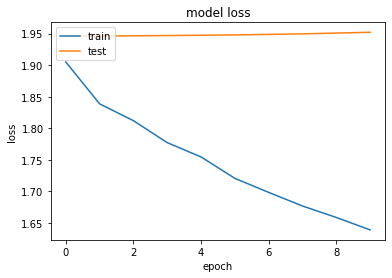

In [124]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/jalcara1/Desktop/ML/saved_models/Emotion_Model.h5 


In [126]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 12.50%


In [127]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

120/120 [==============================] - 1s 9ms/step


array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [128]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues


In [129]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_surprise,120


In [133]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):    
    df_cm = pd.DataFrame( confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.125


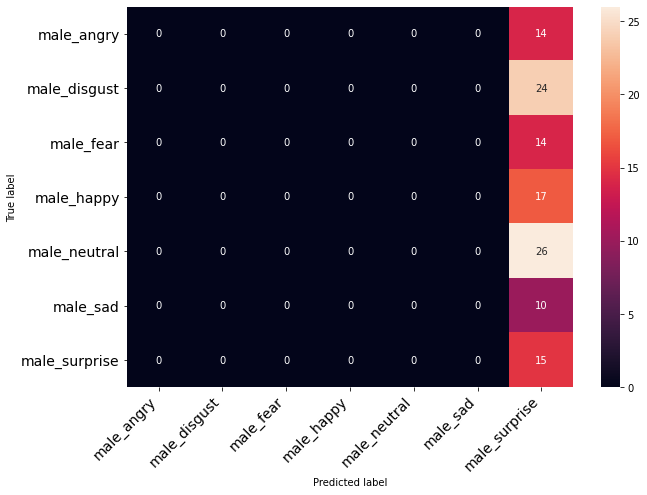

In [134]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [135]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

               precision    recall  f1-score   support

   male_angry       0.00      0.00      0.00        14
 male_disgust       0.00      0.00      0.00        24
    male_fear       0.00      0.00      0.00        14
   male_happy       0.00      0.00      0.00        17
 male_neutral       0.00      0.00      0.00        26
     male_sad       0.00      0.00      0.00        10
male_surprise       0.12      1.00      0.22        15

     accuracy                           0.12       120
    macro avg       0.02      0.14      0.03       120
 weighted avg       0.02      0.12      0.03       120

